In [10]:
# Import necessary libraries 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score,  roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from textblob import TextBlob
import matplotlib.pyplot as plt
from langdetect import detect
import requests
from io import StringIO
from datetime import datetime
import re
import textstat
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
from nltk import bigrams, trigrams
from collections import Counter
import itertools
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/apishant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apishant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/apishant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/apishant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
def load_data_from_github(url):
    # Convert GitHub URL to raw URL format
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')
    response = requests.get(raw_url)
    response.raise_for_status()
    data = StringIO(response.text)
    return pd.read_csv(data, sep='\t')

In [12]:
def load_training_data():
    url = 'https://github.com/apishant22/datasetCOMP3222/blob/main/assignment-comp3222-comp6246-mediaeval2015-dataset/mediaeval-2015-trainingset.txt'
    data_df = load_data_from_github(url)
    return data_df

In [13]:
def load_test_data():
    url = 'https://github.com/apishant22/datasetCOMP3222/blob/main/assignment-comp3222-comp6246-mediaeval2015-dataset/mediaeval-2015-testset.txt'
    test_data_df = load_data_from_github(url)
    return test_data_df

# Dataset Characterization

In [14]:
trainData = load_training_data()
testData = load_test_data()

In [15]:
trainData.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [16]:
# Calculating the percentage of missing data in each column
missing_data_percentage = trainData.isnull().mean() * 100
print(missing_data_percentage)

tweetId       0.0
tweetText     0.0
userId        0.0
imageId(s)    0.0
username      0.0
timestamp     0.0
label         0.0
dtype: float64


In [17]:
def detect_language(text):
    try:
        return detect(text)
    except:
        # If language detection fails, return 'error'
        return 'error'

# Apply the language detection function to each tweet
trainData['language'] = trainData['tweetText'].apply(detect_language)

# Count the number of unique languages and their frequencies in the dataset
language_counts = trainData['language'].value_counts()

print(f"There are {language_counts.size} different languages in the dataset.")
print(language_counts)

There are 44 different languages in the dataset.
language
en       10955
es        1291
tl         313
fr         211
id         179
pt         162
de         127
cy         126
so         118
it         104
nl          84
ar          80
af          72
ru          61
sv          48
pl          37
no          36
ca          35
tr          31
da          28
ja          21
th          19
fi          13
vi          13
et          11
sw          11
zh-cn       10
sq           9
bg           9
sk           9
sl           9
ro           8
hu           6
ko           6
el           5
hr           5
fa           4
lt           4
cs           2
he           1
error        1
mk           1
hi           1
lv           1
Name: count, dtype: int64


# Pipeline Pre-Processing

In [18]:
trainData['label'] = trainData['label'].replace('humor', 'fake')
trainData['label'] = trainData['label'].replace({'fake': 0, 'real': 1})

In [19]:
testData['label'] = testData['label'].replace('humor', 'fake')
testData['label'] = testData['label'].replace({'fake': 0, 'real': 1})

In [20]:
def count_mentions(text):
    return len(re.findall(r'@\w+', text))

trainData['mention_count'] = trainData['tweetText'].apply(count_mentions)
testData['mention_count'] = testData['tweetText'].apply(count_mentions)

In [21]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    # Define patterns for retweets, reposts, and modified tweets
    rt_patterns = [
        "(RT|rt|RP|rp|MT|mt):? @\w*:?",
        "(\bRT\b|\brt\b|\bRP\b|\brp\b|\bMT\b|\bmt\b)",
        "(@\w*:)",
        "(#rt|#RT|#mt|#MT|#rp|#retweet|#Retweet|#repost|#Repost|#modifiedtweet|#modifiedTweet|#ModifiedTweet)",
        "(via @\w*)"
    ]
    # Remove retweets, reposts, and modified tweets
    for pattern in rt_patterns:
        tweet = re.sub(pattern, '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'www\S+', '', tweet)
    tweet = re.sub(r'https\S+', '', tweet)
    tweet = re.sub(r'\\\/\S+', '', tweet)
    # Remove special characters and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    # Remove ampersand and newline characters
    tweet = re.sub(r'&amp;|\\n', '', tweet)
    # Initialize stopwords and extend with additional symbols
    stop_words = set(stopwords.words('english'))
    stop_words.update([':', ';', '[', ']', '"', "'", '(', ')', '.', '?', '#', '@', '...'])
    # Tokenize and remove stopwords
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove extra spaces
    tweet = ' '.join(lemmatized_tokens)
    return tweet

In [22]:
trainData['tweetText'] = trainData['tweetText'].apply(clean_tweet)
testData['tweetText'] = testData['tweetText'].apply(clean_tweet)
print(trainData.head())

              tweetId                                          tweetText  \
0  263046056240115712  se acuerdan de la pelcula el da despus de maan...   
1  262995061304852481  miren sandy en ny tremenda imagen del huracn p...   
2  262979898002534400  buena la foto del huracn sandy recuerda la pel...   
3  262996108400271360                            scary shit hurricane ny   
4  263018881839411200  fave place world nyc hurricane sandy statueofl...   

      userId      imageId(s)        username                       timestamp  \
0   21226711  sandyA_fake_46         iAnnieM  Mon Oct 29 22:34:01 +0000 2012   
1  192378571  sandyA_fake_09  CarlosVerareal  Mon Oct 29 19:11:23 +0000 2012   
2  132303095  sandyA_fake_09     LucasPalape  Mon Oct 29 18:11:08 +0000 2012   
3  241995902  sandyA_fake_29     Haaaaarryyy  Mon Oct 29 19:15:33 +0000 2012   
4  250315890  sandyA_fake_15  princess__natt  Mon Oct 29 20:46:02 +0000 2012   

   label language  mention_count  
0      0       es          

In [23]:
def remove_ids(data):
    # Removes the Id(s) column
    remove_image = data.drop('imageId(s)', axis=1) 
    remove_tweet_ids = remove_image.drop('tweetId', axis=1)
    remove_user_ids = remove_tweet_ids.drop('userId', axis=1)
    remove_username = remove_user_ids.drop('username', axis=1)
    return remove_username

In [24]:
remove_ids(trainData)

,tweetText,timestamp,label,language,mention_count
0,se acuerdan de la pelcula el da despus de maan...,Mon Oct 29 22:34:01 +0000 2012,0,es,0
1,miren sandy en ny tremenda imagen del huracn p...,Mon Oct 29 19:11:23 +0000 2012,0,es,1
2,buena la foto del huracn sandy recuerda la pel...,Mon Oct 29 18:11:08 +0000 2012,0,es,0
3,scary shit hurricane ny,Mon Oct 29 19:15:33 +0000 2012,0,en,0
4,fave place world nyc hurricane sandy statueofl...,Mon Oct 29 20:46:02 +0000 2012,0,en,0
...,...,...,...,...,...
14272,bobombdom slap tweetdeck pigfish,Tue Mar 11 03: 48: 36 +0000 2014,0,en,1
14273,new specie fish found brazil really good photo...,Mon Mar 10 18: 09: 26 +0000 2014,0,en,0
14274,call pigfish,Mon Mar 10 10: 59: 45 +0000 2014,0,en,0
14275,pigfish e dopo il pescecane c il pesce maiale,Sun Mar 09 20: 07: 10 +0000 2014,0,it,0


In [25]:
remove_ids(testData)

,tweetText,timestamp,label,mention_count
0,kereeen eclipse i,Fri Mar 20 09:45:43 +0000 2015,0,1
1,absolutely beautiful eclipse i,Fri Mar 20 11:04:02 +0000 2015,0,1
2,eclipse i wow amazing,Fri Mar 20 12:10:06 +0000 2015,0,1
3,eclipse i,Fri Mar 20 09:12:41 +0000 2015,0,0
4,clipse vue de li autre chose cration divine na...,Fri Mar 20 17:44:11 +0000 2015,0,1
...,...,...,...,...
3750,un prsentateur de la zdf confesse avoir truqu ...,Thu Mar 19 05:49:44 +0000 2015,0,1
3751,oh le kleine menteurs un prsentateur zdf confe...,Thu Mar 19 05:51:42 +0000 2015,0,1
3752,este e el programa de zdf en el que confirman ...,Thu Mar 19 09:23:21 +0000 2015,0,0
3753,wir haben fast mittag riesen verwirrung um var...,Thu Mar 19 10:35:20 +0000 2015,0,0


In [26]:
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity
sia = SentimentIntensityAnalyzer()
def calculate_sentiment(text):
    return sia.polarity_scores(text)['compound']
def unique_word_count(text):
    words = text.split()
    return len(set(words))

trainData['flesch_reading_ease'] = trainData['tweetText'].apply(textstat.flesch_reading_ease)
trainData['gunning_fog'] = trainData['tweetText'].apply(textstat.gunning_fog)
trainData['unique_word_count'] = trainData['tweetText'].apply(unique_word_count)
trainData['polarity'] = trainData['tweetText'].apply(calculate_polarity)
trainData['review_length'] = trainData['tweetText'].apply(len)
trainData['word_count'] = trainData['tweetText'].apply(lambda x: len(x.split()))
trainData['sentiment'] = trainData['tweetText'].apply(calculate_sentiment)

testData['flesch_reading_ease'] = testData['tweetText'].apply(textstat.flesch_reading_ease)
testData['gunning_fog'] = testData['tweetText'].apply(textstat.gunning_fog)
testData['unique_word_count'] = testData['tweetText'].apply(unique_word_count)
testData['polarity'] = testData['tweetText'].apply(calculate_polarity)
testData['review_length'] = testData['tweetText'].apply(len)
testData['word_count'] = testData['tweetText'].apply(lambda x: len(x.split()))
testData['sentiment'] = testData['tweetText'].apply(calculate_sentiment)

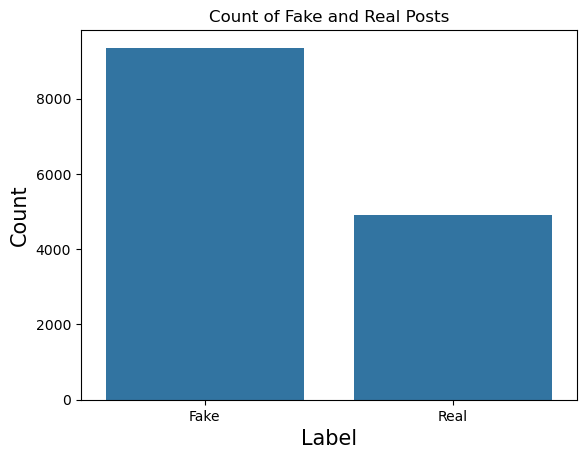

In [27]:
trainData['label_mapped'] = trainData['label'].map({0: 'Fake', 1: 'Real'})

ax = sns.countplot(x='label_mapped', data=trainData)

ax.set(xlabel='Label', ylabel='Count', title='Count of Fake and Real Posts')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

plt.show()

trainData.drop('label_mapped', axis=1, inplace=True)

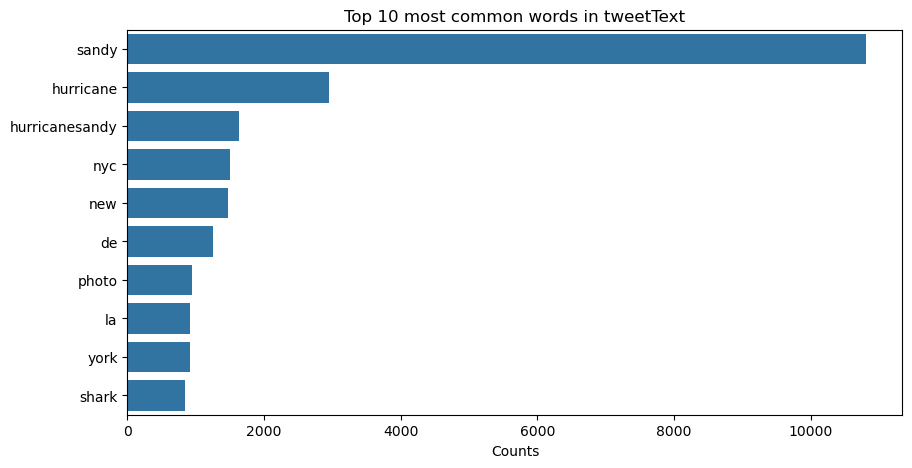

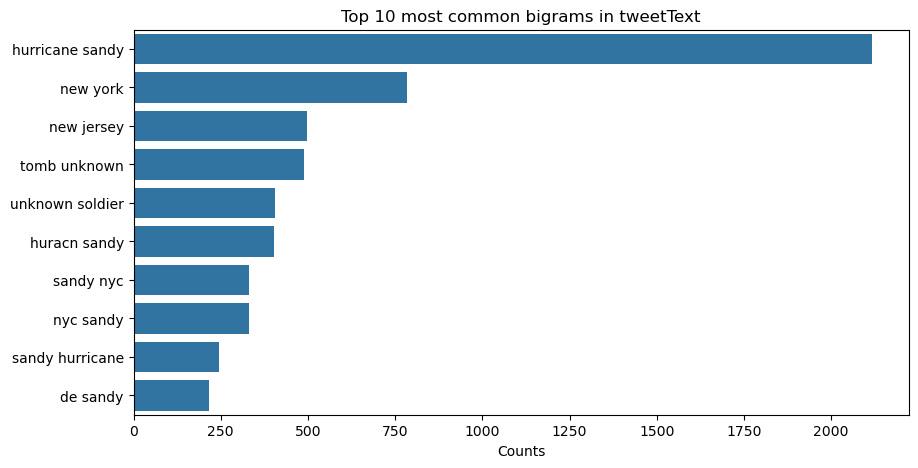

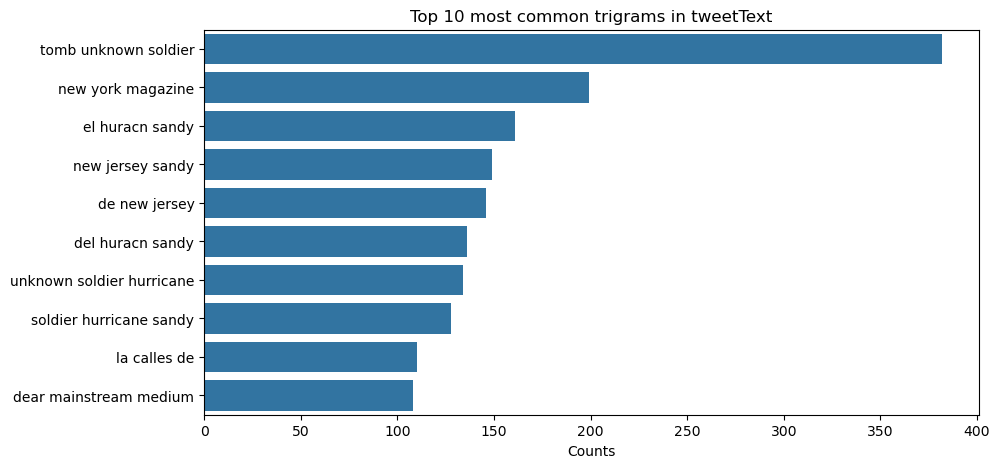

In [28]:
# Tokenize the text into words, bigrams, and trigrams
words = list(itertools.chain(*trainData['tweetText'].apply(word_tokenize)))
bigrams_list = list(itertools.chain(*trainData['tweetText'].apply(lambda x: list(bigrams(word_tokenize(x))))))
trigrams_list = list(itertools.chain(*trainData['tweetText'].apply(lambda x: list(trigrams(word_tokenize(x))))))

# Count the frequencies
word_freq = Counter(words)
bigram_freq = Counter(bigrams_list)
trigram_freq = Counter(trigrams_list)

# Function to plot most common elements
def plot_most_common(elements, title, n=10):
    most_common = elements.most_common(n)
    elements, counts = zip(*most_common)
    elements = [' '.join(element) if isinstance(element, tuple) else element for element in elements]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(elements))
    plt.title(title)
    plt.xlabel('Counts')
    plt.show()

# Plotting
plot_most_common(word_freq, 'Top 10 most common words in tweetText')
plot_most_common(bigram_freq, 'Top 10 most common bigrams in tweetText')
plot_most_common(trigram_freq, 'Top 10 most common trigrams in tweetText')

Top 10 most common words in Fake News Tweets  [('sandy', 6674), ('hurricane', 2183), ('hurricanesandy', 1183), ('new', 968), ('de', 954), ('nyc', 846), ('shark', 845), ('la', 734), ('soldier', 645), ('york', 565)]
Top 10 most common words in Real News Tweets  [('sandy', 4129), ('hurricane', 762), ('nyc', 660), ('photo', 578), ('new', 507), ('cover', 479), ('hurricanesandy', 445), ('york', 343), ('de', 305), ('nymag', 303)]


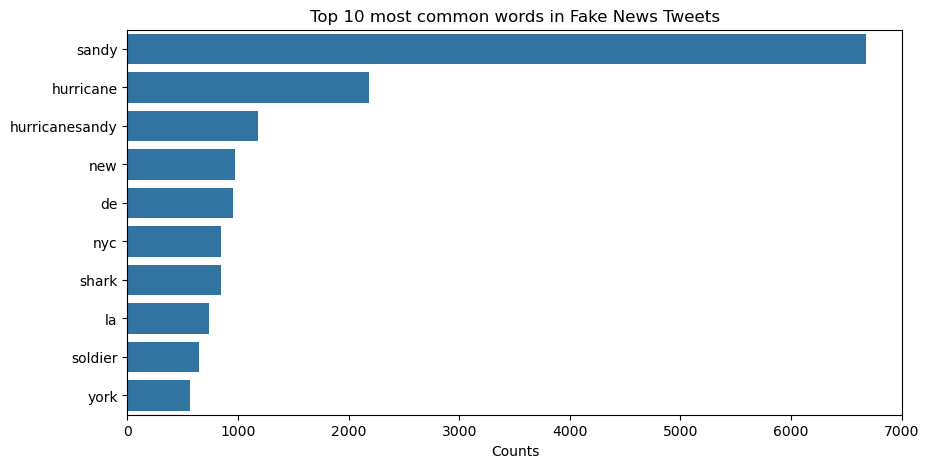

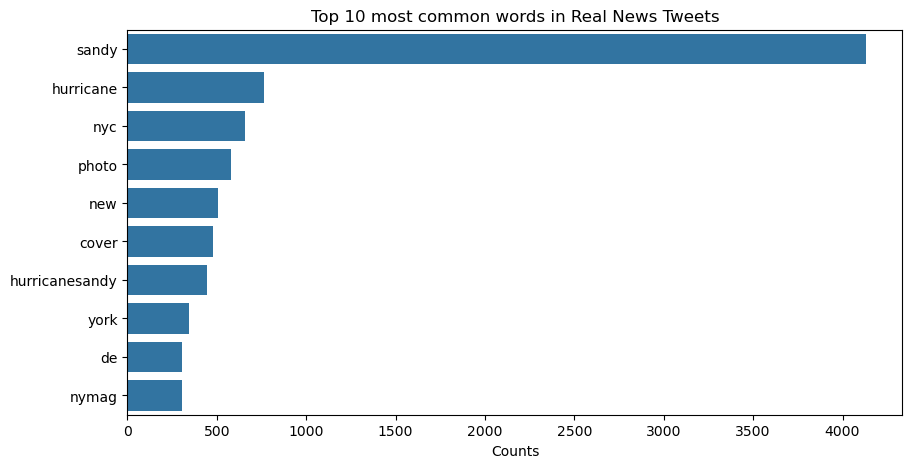

In [29]:
fake_news_tweets = trainData[trainData['label'] == 0]
real_news_tweets = trainData[trainData['label'] == 1]

# Function to tokenize and count words
def count_words(tweets):
    words = list(itertools.chain(*tweets['tweetText'].apply(word_tokenize)))
    return Counter(words)

# Count words for each subset
fake_news_word_freq = count_words(fake_news_tweets)
real_news_word_freq = count_words(real_news_tweets)

print('Top 10 most common words in Fake News Tweets ',fake_news_word_freq.most_common(10))
print('Top 10 most common words in Real News Tweets ', real_news_word_freq.most_common(10))

# Plotting
plot_most_common(fake_news_word_freq, 'Top 10 most common words in Fake News Tweets')
plot_most_common(real_news_word_freq, 'Top 10 most common words in Real News Tweets')

In [30]:
fake_news_tweets['sentiment'] = fake_news_tweets['tweetText'].apply(calculate_sentiment)
average_sentiment = fake_news_tweets['sentiment'].mean()
average_review_length = fake_news_tweets['review_length'].mean()
average_flesch_reading_ease = fake_news_tweets['flesch_reading_ease'].mean()
average_gunning_fog = fake_news_tweets['gunning_fog'].mean()

print("Average Sentiment Score:", average_sentiment)
print("Average Review Length:", average_review_length)
print("Average Flesch Reading Ease:", average_flesch_reading_ease) 
print("Average Gunning Fog:", average_gunning_fog)

Average Sentiment Score: 0.06530112227447628
Average Review Length: 48.003527148353996
Average Flesch Reading Ease: 56.28430846515605
Average Gunning Fog: 9.63626763574177


/var/folders/fy/l72b6qrx24j5fgklc2_vcm9m0000gn/T/ipykernel_12165/2205623334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_tweets['sentiment'] = fake_news_tweets['tweetText'].apply(calculate_sentiment)


In [31]:
real_news_tweets['sentiment'] = real_news_tweets['tweetText'].apply(calculate_sentiment)
average_sentiment = real_news_tweets['sentiment'].mean()
average_review_length = real_news_tweets['review_length'].mean()
average_flesch_reading_ease = real_news_tweets['flesch_reading_ease'].mean()
average_gunning_fog = real_news_tweets['gunning_fog'].mean()

print("Average Sentiment Score:", average_sentiment)
print("Average Review Length:", average_review_length)
print("Average Flesch Reading Ease:", average_flesch_reading_ease) 
print("Average Gunning Fog:", average_gunning_fog)

Average Sentiment Score: 0.09872032107295266
Average Review Length: 51.746189798821376
Average Flesch Reading Ease: 56.67149359886203
Average Gunning Fog: 8.869843527738265


/var/folders/fy/l72b6qrx24j5fgklc2_vcm9m0000gn/T/ipykernel_12165/1913880781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news_tweets['sentiment'] = real_news_tweets['tweetText'].apply(calculate_sentiment)


In [32]:
def extract_time_features(timestamp_str):
    # List of possible timestamp formats
    format_strs = [
        '%a %b %d %H:%M:%S +0000 %Y',  # Standard format
        '%a %b %d %H: %M: %S +0000 %Y'  # Format with spaces around colons
    ]
    
    for format_str in format_strs:
        try:
            timestamp = datetime.strptime(timestamp_str, format_str)
            day_of_week = timestamp.weekday()
            hour_of_day = timestamp.hour
            return day_of_week, hour_of_day
        except ValueError:
            continue 

    print(f"Error parsing timestamp '{timestamp_str}'")
    return None, None

trainData['day_of_week'], trainData['hour_of_day'] = zip(*trainData['timestamp'].apply(extract_time_features))
trainData.drop(columns=['timestamp'], inplace=True)
trainData.drop(columns=['tweetId'], inplace=True)
trainData.drop(columns=['userId'], inplace=True)
trainData.drop(columns=['username'], inplace=True)
trainData.drop(columns=['imageId(s)'], inplace=True)
columns_order = [col for col in trainData.columns if col != 'label'] + ['label']
trainData = trainData[columns_order]
print(trainData)

testData['day_of_week'], testData['hour_of_day'] = zip(*testData['timestamp'].apply(extract_time_features))
testData.drop(columns=['timestamp'], inplace=True)
testData.drop(columns=['tweetId'], inplace=True)
testData.drop(columns=['userId'], inplace=True)
testData.drop(columns=['username'], inplace=True)
testData.drop(columns=['imageId(s)'], inplace=True)
columns_order = [col for col in testData.columns if col != 'label'] + ['label']
testData = testData[columns_order]

                                               tweetText language  \
0      se acuerdan de la pelcula el da despus de maan...       es   
1      miren sandy en ny tremenda imagen del huracn p...       es   
2      buena la foto del huracn sandy recuerda la pel...       es   
3                                scary shit hurricane ny       en   
4      fave place world nyc hurricane sandy statueofl...       en   
...                                                  ...      ...   
14272                   bobombdom slap tweetdeck pigfish       en   
14273  new specie fish found brazil really good photo...       en   
14274                                       call pigfish       en   
14275      pigfish e dopo il pescecane c il pesce maiale       it   
14276                       cant decide fish meatpigfish       en   

       mention_count  flesch_reading_ease  gunning_fog  unique_word_count  \
0                  0                60.65        13.92                 17   
1                

# Machine Learning Algorithm Training

In [33]:
# Imports for Logistic Regression 
from sklearn.linear_model import LogisticRegression

In [34]:
# Imports for Random Forest 
from sklearn.ensemble import RandomForestClassifier

In [35]:
import tensorflow as tf

# List physical devices to confirm TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Fake', 'True'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Fake', 'True'], rotation=0)
    plt.show()

In [37]:
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

In [38]:
vectorizer = TfidfVectorizer(max_features=12619)
tfidf_matrix = vectorizer.fit_transform(trainData['tweetText'])
tfidf_matrix.shape

(14277, 12267)

In [39]:
additional_features = trainData[['polarity','gunning_fog', 'sentiment']]
X_combined = np.hstack((tfidf_matrix.toarray(), additional_features.values))

In [40]:
y=trainData['label']
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 9356, 1: 4921})


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
smote = SMOTE(sampling_strategy=1, random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f'Original dataset shape : {Counter(y_train_resampled)}')

Original dataset shape : Counter({0: 7484, 1: 7484})


In [33]:
# Initialize the classifiers
logreg_cv = LogisticRegression(random_state=0, max_iter=2000)
rf_cv = RandomForestClassifier(random_state=0)

# Dictionary and list of models
cv_dict = {0: 'Logistic Regression', 1: 'Random Forest'}
cv_models = [logreg_cv, rf_cv]

# Print the cross-validation accuracy
for i, model in enumerate(cv_models):
    cv_accuracy = cross_val_score(model, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy').mean()
    print(f"{cv_dict[i]} Test Accuracy: {cv_accuracy}")

Logistic Regression Test Accuracy: 0.9063353534162799
Random Forest Test Accuracy: 0.9261150643533055


In [ ]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np

# Sample dataset dimensions
num_features = X_train_resampled.shape[1]
num_samples = X_train_resampled.shape[0]

# Define a simple neural network model for binary classification
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Prepare K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Lists to store results of K-fold CV
accuracies = []

for train, test in kfold.split(X_train_resampled, y_train_resampled):
    model = create_model()
    # Train model
    model.fit(X_train_resampled[train], y_train_resampled[train], epochs=10, batch_size=32, verbose=0)
    # Evaluate model
    _, accuracy = model.evaluate(X_train_resampled[test], y_train_resampled[test], verbose=0)
    accuracies.append(accuracy)

# Print average accuracy across all folds
print(f'Average Test Accuracy: {np.mean(accuracies)}')


In [311]:
# Not used anymore
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Hyperparameter Tuning for Logistic Regression
#This may take a while to run so I passed the parameters I got after running it.
space = {
    'C': hp.choice('C', [0.01, 0.1, 1, 10]), 
    'max_iter': hp.choice('max_iter', [5000, 10000]),
    'solver': hp.choice('solver', ['lbfgs', 'saga']),
    'class_weight': hp.choice('class_weight', ['balanced'])
}

def objective(params):
    clf = LogisticRegression(**params, random_state=0, n_jobs=-1)
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=3, scoring='f1').mean()
    return {'loss': -score, 'status': 'ok'}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best_params = space_eval(space, best)
print("Best Parameters:", best_params)

In [35]:
print(best_params)

{'C': 1, 'class_weight': 'balanced', 'max_iter': 5000, 'solver': 'lbfgs'}


In [ ]:
# logreg = LogisticRegression(**best_params, random_state=0)
logreg = LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000, solver='saga', random_state=0)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)
accuracy = logreg.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))

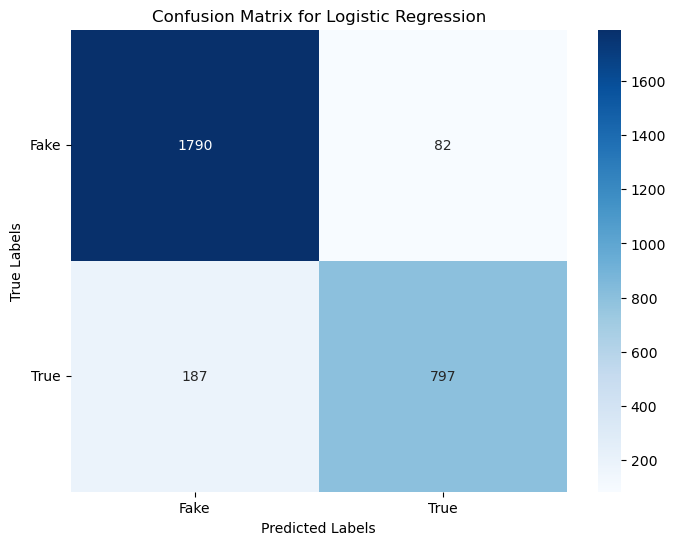

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1872
           1       0.91      0.81      0.86       984

    accuracy                           0.91      2856
   macro avg       0.91      0.88      0.89      2856
weighted avg       0.91      0.91      0.90      2856



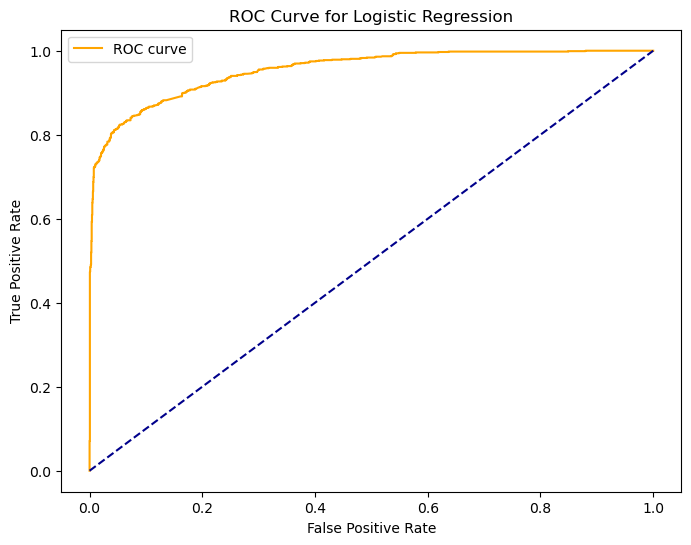

ROC-AUC score for Logistic Regression: 0.9542392489229379


In [37]:
# Logistic Regression - Confusion Matrix
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for Logistic Regression')

# Logistic Regression - Classification Report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Logistic Regression - ROC-AUC Curvew
y_scores_lr = logreg.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores_lr, 'ROC Curve for Logistic Regression')
print('ROC-AUC score for Logistic Regression:', roc_auc_score(y_test, y_scores_lr))

In [38]:
#Hyperparameter Tuning for Random Forest
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300]), 
    'max_depth': hp.choice('max_depth', [5, 10, 15, 20, 30, None]),  
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]), 
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]), 
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

def objective(params):
    clf = RandomForestClassifier(**params, random_state=0, n_jobs=-1, oob_score=True)
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': 'ok'}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best_params_rf = space_eval(space, best)
print("Best Parameters:", best_params_rf)

100%|█| 10/10 [09:39<00:00, 57.93s/trial, best loss: -0.8754697341
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}


In [39]:
print(best_params_rf)
best_params_rf = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}


In [40]:
rf = RandomForestClassifier(**best_params_rf, random_state=0)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
accuracy_rf = rf.score(X_test, y_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_rf))

Accuracy of random forest classifier on test set: 0.88


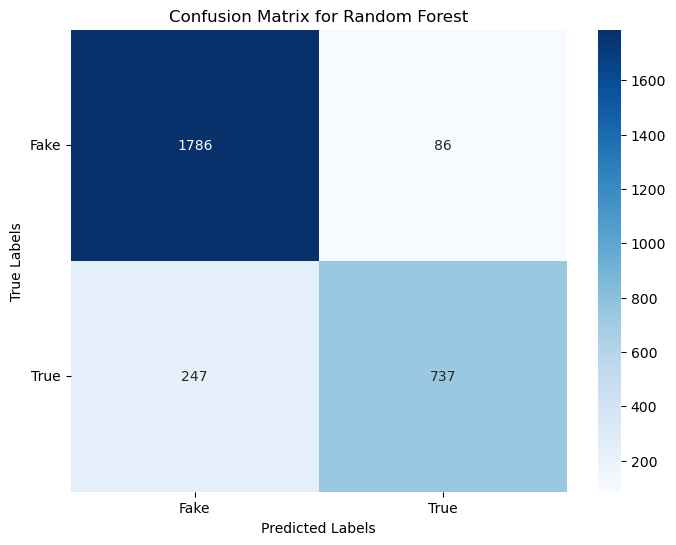

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1872
           1       0.90      0.75      0.82       984

    accuracy                           0.88      2856
   macro avg       0.89      0.85      0.87      2856
weighted avg       0.88      0.88      0.88      2856



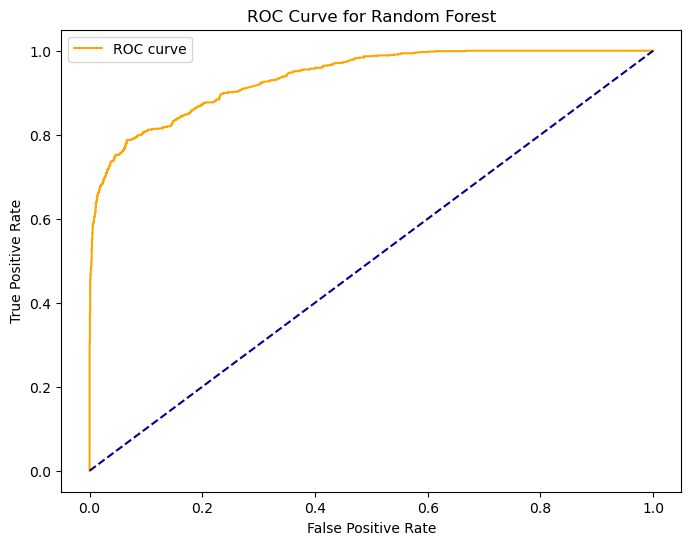

ROC-AUC score for Random Forest: 0.9366020863734279


In [41]:
# Random Forest - Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix for Random Forest')

# Random Forest - Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Random Forest - ROC-AUC Curve
y_scores_rf = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores_rf, 'ROC Curve for Random Forest')
print('ROC-AUC score for Random Forest:', roc_auc_score(y_test, y_scores_rf))

# Machine Learning Algorithm Testing

In [42]:
X_test = vectorizer.transform(testData['tweetText'])
additional_features_test = testData[['polarity','gunning_fog', 'sentiment']].values
X_test_combined = np.hstack((X_test.toarray(), additional_features_test))

In [43]:
true_labels = testData['label'] 

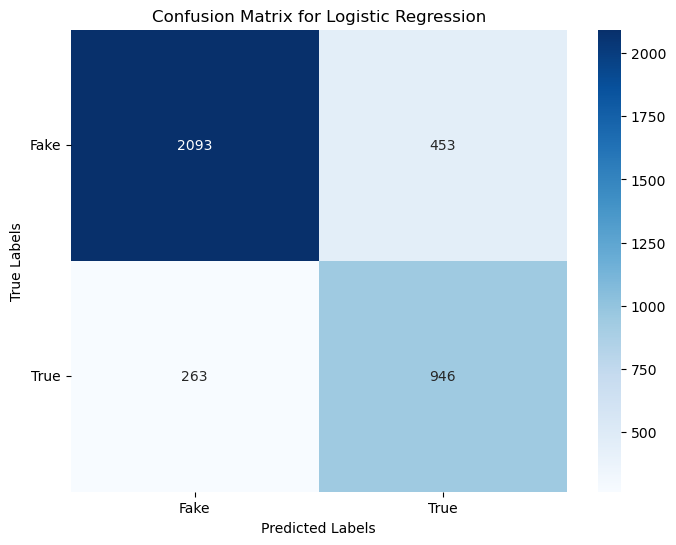

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2546
           1       0.68      0.78      0.73      1209

    accuracy                           0.81      3755
   macro avg       0.78      0.80      0.79      3755
weighted avg       0.82      0.81      0.81      3755

Logistic Regression F1 Score: 0.7896986456010192


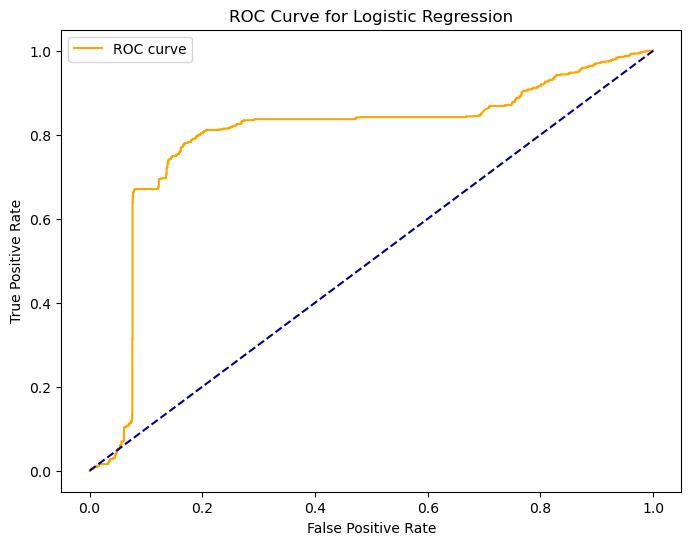

ROC-AUC score for Logistic Regression: 0.792891198961442


In [44]:
y_pred_lr = logreg.predict(X_test_combined)
# Evaluation for Logistic Regression
plot_confusion_matrix(true_labels, y_pred_lr, 'Confusion Matrix for Logistic Regression')
print("Logistic Regression Classification Report:")
print(classification_report(true_labels, y_pred_lr))
print("Logistic Regression F1 Score:", f1_score(true_labels, y_pred_lr, average='macro'))
# Logistic Regression - ROC-AUC Curvew
y_scores_lr = logreg.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(true_labels, y_scores_lr, 'ROC Curve for Logistic Regression')
print('ROC-AUC score for Logistic Regression:', roc_auc_score(true_labels, y_scores_lr))

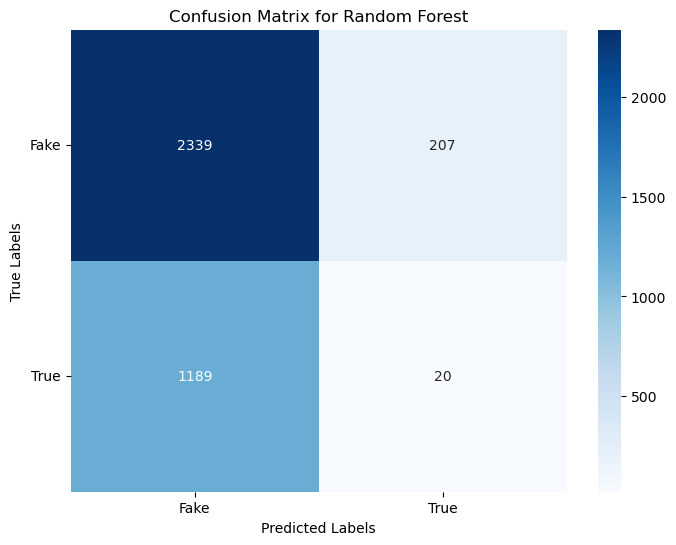

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      2546
           1       0.09      0.02      0.03      1209

    accuracy                           0.63      3755
   macro avg       0.38      0.47      0.40      3755
weighted avg       0.48      0.63      0.53      3755

Random Forest F1 Score: 0.3990115410402621


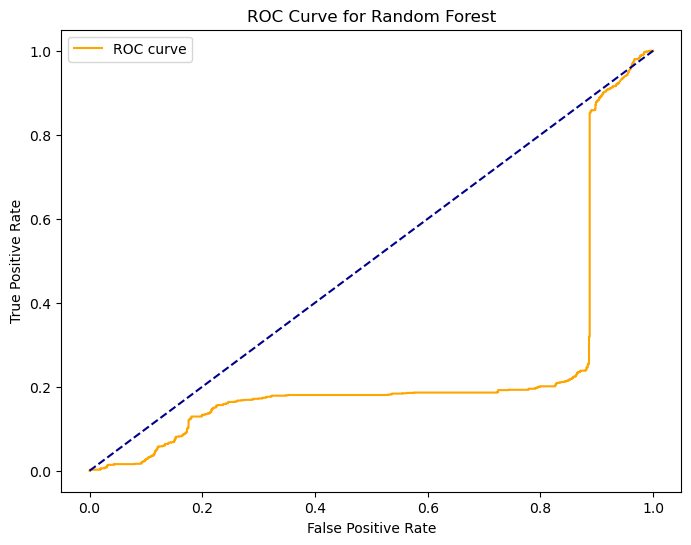

ROC-AUC score for Random Forest: 0.24155018300166922


In [45]:
y_pred_rf = rf.predict(X_test_combined)
# Evaluation for Random Forest
plot_confusion_matrix(true_labels, y_pred_rf, 'Confusion Matrix for Random Forest')
print("Random Forest Classification Report:")
print(classification_report(true_labels, y_pred_rf))
print("Random Forest F1 Score:", f1_score(true_labels, y_pred_rf, average='macro'))
# Random Forest - ROC-AUC Curve
y_scores_rf = rf.predict_proba(X_test_combined)[:, 1]
plot_roc_curve(true_labels, y_scores_rf, 'ROC Curve for Random Forest')
print('ROC-AUC score for Random Forest:', roc_auc_score(true_labels, y_scores_rf))